In [1]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
data = pd.read_csv('adult.csv')#, header = None)
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
#pip install xgboost

In [3]:
#attribute information can be found from this link: http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [5]:
#Here the data points are huge near about 50K.
#we can do one thing: take 30% data from it randomly
#build model locally
#train it through google colab in the jupyter notebook namely ML_adult_Boosting.ipynb
#upload it in github repo
#deploy in Heroku or other platforms

#####  Quick Data Investigation

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


##### Investigate on object type data

In [7]:
objs=['workclass','education','marital-status','occupation','relationship','race','gender','native-country','income']
for obj in objs:
    print(obj, data[obj].unique())
    print()

workclass ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']

marital-status ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']

occupation ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces']

relationship ['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']

race ['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']

gender ['Male' 'Female']

native-country ['United-States' '?' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philip

In [8]:
#we have seen that two columns ['occupation','native-country'] has entries '?'.
#we have to clean those data points at first.
#Before that we will enquire how many of them 

In [9]:
raw_cols=['workclass','occupation','native-country']
for cols in raw_cols:
    print(cols)
    print(data[cols].value_counts())
    print()

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
?                    2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

native-country
United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador              

In [10]:
data["workclass"].replace("?", np.nan, inplace=True)
data["occupation"].replace("?", np.nan, inplace=True)
data["native-country"].replace("?", np.nan, inplace=True)
#I don't know why it is not working.

In [11]:
raw_cols=['workclass','occupation','native-country']
for cols in raw_cols:
    print(cols)
    print(data[cols].value_counts())
    print()

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

native-country
United-States                 43832
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
Engla

In [12]:
data.shape

(48842, 15)

In [13]:
dataa=data.copy()

In [14]:
dataa.shape

(48842, 15)

In [15]:
dataa.dropna(inplace=True)

In [16]:
dataa.shape

(45222, 15)

In [17]:
dataa.to_csv('adult_row_removed.csv')

In [4]:
dataa=pd.read_csv('adult_row_removed.csv')

In [5]:
dataa.shape

(45222, 15)

In [6]:
dataa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45222 non-null  int64 
 1   workclass        45222 non-null  object
 2   fnlwgt           45222 non-null  int64 
 3   education        45222 non-null  object
 4   educational-num  45222 non-null  int64 
 5   marital-status   45222 non-null  object
 6   occupation       45222 non-null  object
 7   relationship     45222 non-null  object
 8   race             45222 non-null  object
 9   gender           45222 non-null  object
 10  capital-gain     45222 non-null  int64 
 11  capital-loss     45222 non-null  int64 
 12  hours-per-week   45222 non-null  int64 
 13  native-country   45222 non-null  object
 14  income           45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.2+ MB


In [7]:
#Basically this is nothing but a classification problem
#Take income <=50K and >50K as numerical values 0 and 1 respectively.
dataa['income'].replace('<=50K',0,inplace=True)
dataa['income'].replace('>50K',1,inplace=True)

In [8]:
dataa

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
45218,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
45219,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
45220,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


##### Handling Categorical columns

In [9]:
num_data=dataa.copy()

In [10]:
le=preprocessing.LabelEncoder()
le.fit(dataa['gender'])
num_data['gender']=list(le.transform(dataa['gender']))

In [11]:
cl=list(le.classes_)
num_cl=list(le.transform(cl))
list(zip(cl,num_cl))

[('Female', 0), ('Male', 1)]

In [12]:
le.fit(num_data['workclass'])
num_data['workclass']=list(le.transform(dataa['workclass']))

In [13]:
cl=list(le.classes_)
num_cl=list(le.transform(cl))
list(zip(cl,num_cl))

[('Federal-gov', 0),
 ('Local-gov', 1),
 ('Private', 2),
 ('Self-emp-inc', 3),
 ('Self-emp-not-inc', 4),
 ('State-gov', 5),
 ('Without-pay', 6)]

In [14]:
#Here we see that educational-num represents numeric data corresponding to education.
#Then we have to remove the column education.
num_data.drop(columns=['education'],inplace=True)

In [15]:
#We want to rename the column educational-num
num_data=num_data.rename(columns={'educational-num':'edu'})

In [16]:
num_data.head()

,age,workclass,fnlwgt,edu,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,2,226802,7,Never-married,Machine-op-inspct,Own-child,Black,1,0,0,40,United-States,0
1,38,2,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,1,0,0,50,United-States,0
2,28,1,336951,12,Married-civ-spouse,Protective-serv,Husband,White,1,0,0,40,United-States,1
3,44,2,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,1,7688,0,40,United-States,1
4,34,2,198693,6,Never-married,Other-service,Not-in-family,White,1,0,0,30,United-States,0


In [17]:
le.fit(num_data['marital-status'])
num_data['marital-status']=list(le.transform(dataa['marital-status']))

In [18]:
cl=list(le.classes_)
num_cl=list(le.transform(cl))
list(zip(cl,num_cl))

[('Divorced', 0),
 ('Married-AF-spouse', 1),
 ('Married-civ-spouse', 2),
 ('Married-spouse-absent', 3),
 ('Never-married', 4),
 ('Separated', 5),
 ('Widowed', 6)]

In [19]:
le.fit(num_data['occupation'])
num_data['occupation']=list(le.transform(dataa['occupation']))

In [20]:
cl=list(le.classes_)
num_cl=list(le.transform(cl))
list(zip(cl,num_cl))

[('Adm-clerical', 0),
 ('Armed-Forces', 1),
 ('Craft-repair', 2),
 ('Exec-managerial', 3),
 ('Farming-fishing', 4),
 ('Handlers-cleaners', 5),
 ('Machine-op-inspct', 6),
 ('Other-service', 7),
 ('Priv-house-serv', 8),
 ('Prof-specialty', 9),
 ('Protective-serv', 10),
 ('Sales', 11),
 ('Tech-support', 12),
 ('Transport-moving', 13)]

In [21]:
le.fit(num_data['relationship'])
num_data['relationship']=list(le.transform(dataa['relationship']))

In [22]:
cl=list(le.classes_)
num_cl=list(le.transform(cl))
list(zip(cl,num_cl))

[('Husband', 0),
 ('Not-in-family', 1),
 ('Other-relative', 2),
 ('Own-child', 3),
 ('Unmarried', 4),
 ('Wife', 5)]

In [23]:
le.fit(num_data['race'])
num_data['race']=list(le.transform(dataa['race']))

In [24]:
cl=list(le.classes_)
num_cl=list(le.transform(cl))
list(zip(cl,num_cl))

[('Amer-Indian-Eskimo', 0),
 ('Asian-Pac-Islander', 1),
 ('Black', 2),
 ('Other', 3),
 ('White', 4)]

In [25]:
num_data

,age,workclass,fnlwgt,edu,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,2,226802,7,4,6,3,2,1,0,0,40,United-States,0
1,38,2,89814,9,2,4,0,4,1,0,0,50,United-States,0
2,28,1,336951,12,2,10,0,4,1,0,0,40,United-States,1
3,44,2,160323,10,2,6,0,2,1,7688,0,40,United-States,1
4,34,2,198693,6,4,7,1,4,1,0,0,30,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,27,2,257302,12,2,12,5,4,0,0,0,38,United-States,0
45218,40,2,154374,9,2,6,0,4,1,0,0,40,United-States,1
45219,58,2,151910,9,6,0,4,4,0,0,0,40,United-States,0
45220,22,2,201490,9,4,0,3,4,1,0,0,20,United-States,0


<AxesSubplot:xlabel='native-country', ylabel='count'>

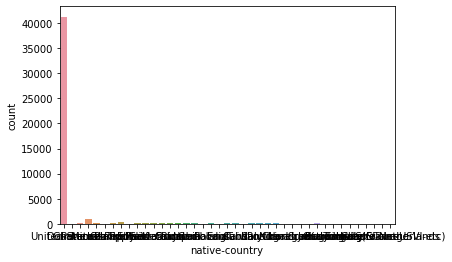

In [26]:
sns.countplot(x='native-country',data=num_data)

In [27]:
num_data['native-country'].value_counts()

United-States                 41292
Mexico                          903
Philippines                     283
Germany                         193
Puerto-Rico                     175
Canada                          163
El-Salvador                     147
India                           147
Cuba                            133
England                         119
China                           113
Jamaica                         103
South                           101
Italy                           100
Dominican-Republic               97
Japan                            89
Guatemala                        86
Vietnam                          83
Columbia                         82
Poland                           81
Haiti                            69
Portugal                         62
Iran                             56
Taiwan                           55
Greece                           49
Nicaragua                        48
Peru                             45
Ecuador                     

In [28]:
#we see that only 8% data are from different countries.
#First of all we wol

In [29]:
le.fit(num_data['native-country'])
num_data['native-country']=list(le.transform(dataa['native-country']))

In [30]:
cl=list(le.classes_)
num_cl=list(le.transform(cl))
list(zip(cl,num_cl))

[('Cambodia', 0),
 ('Canada', 1),
 ('China', 2),
 ('Columbia', 3),
 ('Cuba', 4),
 ('Dominican-Republic', 5),
 ('Ecuador', 6),
 ('El-Salvador', 7),
 ('England', 8),
 ('France', 9),
 ('Germany', 10),
 ('Greece', 11),
 ('Guatemala', 12),
 ('Haiti', 13),
 ('Holand-Netherlands', 14),
 ('Honduras', 15),
 ('Hong', 16),
 ('Hungary', 17),
 ('India', 18),
 ('Iran', 19),
 ('Ireland', 20),
 ('Italy', 21),
 ('Jamaica', 22),
 ('Japan', 23),
 ('Laos', 24),
 ('Mexico', 25),
 ('Nicaragua', 26),
 ('Outlying-US(Guam-USVI-etc)', 27),
 ('Peru', 28),
 ('Philippines', 29),
 ('Poland', 30),
 ('Portugal', 31),
 ('Puerto-Rico', 32),
 ('Scotland', 33),
 ('South', 34),
 ('Taiwan', 35),
 ('Thailand', 36),
 ('Trinadad&Tobago', 37),
 ('United-States', 38),
 ('Vietnam', 39),
 ('Yugoslavia', 40)]

In [31]:
num_data.head(5)

,age,workclass,fnlwgt,edu,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,2,226802,7,4,6,3,2,1,0,0,40,38,0
1,38,2,89814,9,2,4,0,4,1,0,0,50,38,0
2,28,1,336951,12,2,10,0,4,1,0,0,40,38,1
3,44,2,160323,10,2,6,0,2,1,7688,0,40,38,1
4,34,2,198693,6,4,7,1,4,1,0,0,30,38,0


In [32]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             45222 non-null  int64
 1   workclass       45222 non-null  int64
 2   fnlwgt          45222 non-null  int64
 3   edu             45222 non-null  int64
 4   marital-status  45222 non-null  int64
 5   occupation      45222 non-null  int64
 6   relationship    45222 non-null  int64
 7   race            45222 non-null  int64
 8   gender          45222 non-null  int64
 9   capital-gain    45222 non-null  int64
 10  capital-loss    45222 non-null  int64
 11  hours-per-week  45222 non-null  int64
 12  native-country  45222 non-null  int64
 13  income          45222 non-null  int64
dtypes: int64(14)
memory usage: 4.8 MB


In [84]:
num_data.corr()

,age,workclass,fnlwgt,edu,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
age,1.000000,0.085892,-0.075792,0.037623,-0.271623,-0.004474,-0.247564,0.023776,0.082053,0.079683,0.059351,0.101992,-0.003180,0.237040
workclass,0.085892,1.000000,-0.034970,0.040779,-0.033221,0.017508,-0.065049,0.049765,0.069638,0.034543,0.008233,0.051366,0.003889,0.015659
fnlwgt,-0.075792,-0.034970,1.000000,-0.041993,0.033096,-0.002036,0.009909,-0.029188,0.027240,-0.004110,-0.004349,-0.018679,-0.061098,-0.007264
edu,0.037623,0.040779,-0.041993,1.000000,-0.064986,0.089686,-0.088431,0.031655,0.003417,0.126907,0.081711,0.146206,0.092994,0.332800
marital-status,-0.271623,-0.033221,0.033096,-0.064986,1.000000,0.016399,0.180436,-0.070302,-0.120008,-0.042399,-0.034820,-0.183178,-0.022721,-0.192711
occupation,-0.004474,0.017508,-0.002036,0.089686,0.016399,1.000000,-0.051644,-0.000026,0.056625,0.019435,0.015267,0.016160,-0.002848,0.049787
relationship,-0.247564,-0.065049,0.009909,-0.088431,0.180436,-0.051644,1.000000,-0.118584,-0.582974,-0.056818,-0.058425,-0.259194,-0.007144,-0.253402
race,0.023776,0.049765,-0.029188,0.031655,-0.070302,-0.000026,-0.118584,1.000000,0.088935,0.014078,0.020955,0.044738,0.124342,0.070844
gender,0.082053,0.069638,0.027240,0.003417,-0.120008,0.056625,-0.582974,0.088935,1.000000,0.047444,0.046457,0.231425,-0.004170,0.215760
capital-gain,0.079683,0.034543,-0.004110,0.126907,-0.042399,0.019435,-0.056818,0.014078,0.047444,1.000000,-0.032102,0.083880,0.007643,0.221034


<AxesSubplot:>

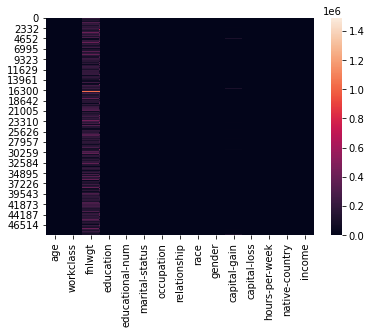

In [63]:
sns.heatmap(num_data)

In [85]:
#At first we will train our model and test before further pre-processing.

In [33]:
x=num_data.drop(columns='income',axis=1)
y=num_data['income']

In [34]:
# as the datapoints differ a lot in magnitude, we'll scale them
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_data=scaler.fit_transform(x)

In [35]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(scaled_data,y,test_size=0.3,random_state=42)

In [36]:
# fit model no training data
model = XGBClassifier(objective='binary:logistic')
model.fit(train_x, train_y)

C:\Users\ANKDIP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [37]:
# cheking training accuracy
y_pred = model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
accuracy

0.89935239298689

In [38]:
# cheking initial test accuracy
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
accuracy

0.8704208741799956

In [39]:
test_x[0]

array([-1.47891885,  1.87399717, -1.50452199, -1.61327742,  0.27646546,
       -1.48262433,  1.61988954, -4.42159787, -1.44130956, -0.1467332 ,
       -0.21878026, -0.07812006,  0.26299899])

In [40]:
test_y[1]

0

In [41]:
y_pred[1]

0

In [42]:
#Saving the Model
import pickle
filename='final_model.pickle'
pickle.dump(model,open(filename,'wb'))

with open('standardScaler.pickle', 'wb') as f:
    pickle.dump(scaler,f)

In [100]:
l=[('Federal-gov', 0),('Local-gov', 1),('Private', 2),('Self-emp-inc', 3),('Self-emp-not-inc', 4),('State-gov', 5),('Without-pay', 6)]

In [101]:
l[0]

('Federal-gov', 0)

In [103]:
type(l)

list

In [105]:
p={k[0]:k[1] for k in l}

In [106]:
p

{'Federal-gov': 0,
 'Local-gov': 1,
 'Private': 2,
 'Self-emp-inc': 3,
 'Self-emp-not-inc': 4,
 'State-gov': 5,
 'Without-pay': 6}

In [107]:
p['Private']

2